# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [399]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
df_fights = pd.read_csv("data/data.csv")
df_fights["date"] = pd.to_datetime(df_fights["date"])
df_fights.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


# Analysis

In [4]:
sample_dates = ["2008-01-01", "2009-01-01", "2010-01-01", "2011-01-01", "2012-01-01", "2013-01-01", "2014-01-01"]

## Win loss draw rating

In [5]:
df_fighters = pd.concat([df_fights[["R_fighter", "date", "R_wins", "R_losses", "R_draw"]].rename(columns={
    "R_fighter":"fighter",
    "R_wins":"wins",
    "R_losses":"losses",
    "R_draw":"draw"}), df_fights[["B_fighter", "date", "B_wins", "B_losses", "B_draw"]].rename(columns={
    "B_fighter":"fighter",
    "B_wins":"wins",
    "B_losses":"losses",
    "B_draw":"draw"})]).sort_values(by="date").groupby("fighter").agg(["first", "last"]).reset_index()

df_fighters.head()

fighter       date             wins      losses       draw     
                       first       last first last  first last first last
0      Aalon Cruz 2020-02-29 2021-03-06     0    0      0    1     0    0
1     Aaron Brink 2000-11-17 2000-11-17     0    0      0    0     0    0
2  Aaron Phillips 2014-05-24 2020-07-15     0    0      0    2     0    0
3     Aaron Riley 2002-05-10 2013-07-27     0    3      0    5     0    0
4      Aaron Rosa 2011-06-11 2012-03-02     0    1      0    1     0    0

Text(0.5, 1.0, 'Evolution of the number of active fighters in UFC')

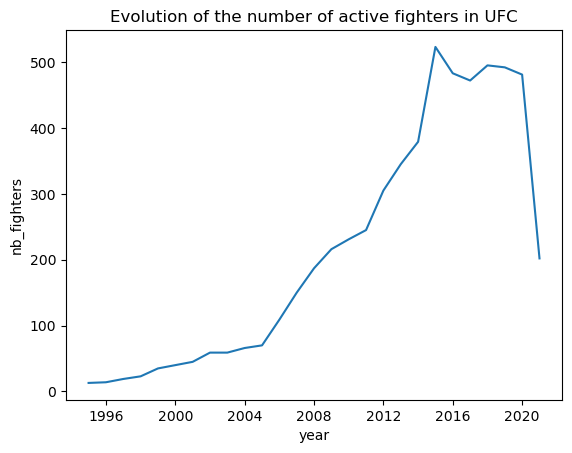

In [6]:
start, end = df_fighters["date", "first"].min(), df_fighters["date", "last"].max()
s_date_range = pd.Series(pd.date_range(start, end, freq="Y"))
plt.plot(s_date_range, s_date_range.apply(lambda u : ((df_fighters["date", "first"]<=u) 
                               & (df_fighters["date", "last"]>=u)
                               ).sum()))
plt.xlabel("year")
plt.ylabel("nb_fighters")
plt.title("Evolution of the number of active fighters in UFC")

In [7]:
def ranking_winLossDraw(w, l, d, alpha=0, offset=0):
    """simple ranking based on win/loss/draw informations.

    Args:
        w (int): number of wins
        l (int): number of losses
        d (int): number of draws
        alpha (int, optional): penalization term for the losses in [-1, +inf]. Close to -1 : . Defaults to 0.
        offset (int, optional): offset to avoid fighters with few matches to be extremely well rated. Defaults to 0.

    Returns:
        _type_: ranking between 0 and 1
    """
    return (w - alpha*l +.5*d - 0.5*alpha*d)/(w+l+d+offset)

def format_dataframeFighterRecord(fighter_corner):
    df = df_fights[[fighter_corner, "date", "Winner", "title_bout", "weight_class"]].copy()
    if fighter_corner == "R_fighter":
        condition_won = "Red"
        condition_lost = "Blue"
    elif fighter_corner == "B_fighter":
        condition_won = "Blue"
        condition_lost = "Red"
    
    df["won"] = df["Winner"].apply(lambda u: u == condition_won)
    df["lost"] = df["Winner"].apply(lambda u: u == condition_lost)
    df["draw"] = df["Winner"].apply(lambda u: u == "Draw")
    df = df.rename(columns={fighter_corner:"fighter"}).drop(columns="Winner")
    return df

df = pd.concat([format_dataframeFighterRecord("B_fighter"), format_dataframeFighterRecord("R_fighter")]).sort_values(by="date").reset_index(drop=True)
df_ratings = pd.merge(df, df.groupby("fighter")[["won", "lost", "draw"]].transform("cumsum").rename(columns={
                                                                                        "won":"won_total",
                                                                                        "lost":"lost_total",
                                                                                        "draw":"draw_total"}),
                                                                                                how="left", left_index=True, right_index=True)
df_ratings["n_fights"] = df_ratings["won_total"] + df_ratings["lost_total"] + df_ratings["draw_total"]
df_ratings["simple_ratings"] = df_ratings.apply(lambda u : ranking_winLossDraw(u["won_total"], u["lost_total"], u["draw_total"], alpha=1, offset=1), axis=1)
df_ratings

,fighter,date,title_bout,weight_class,won,lost,draw,won_total,lost_total,draw_total,n_fights,simple_ratings
0,Sean Daugherty,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
1,Remco Pardoel,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
2,Orlando Wiet,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
3,Johnny Rhodes,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
4,Fred Ettish,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
12019,Derek Brunson,2021-03-20,False,Middleweight,True,False,False,13,5,0,18,0.421053
12020,Montel Jackson,2021-03-20,False,Bantamweight,True,False,False,4,2,0,6,0.285714
12021,Bruno Silva,2021-03-20,False,Flyweight,True,False,False,1,2,1,4,-0.200000
12022,Trevin Giles,2021-03-20,False,Middleweight,True,False,False,5,2,0,7,0.375000


**A word on ranking by wins, losses and draws**\
The term $\frac{1}{2} d (1-\alpha)$ is introduced because we consider a draw to be half a win and half a loss.

Particuliar cases of the simple ranking:
- alpha = 0 (and offset = 0) : rating becomes win percentage
- alpha = -1 (and offset = 0) : rating becomes degenerate


However this simple ranking approach is not taking into account the strength of the opponent.

c:\Users\leroy\anaconda3\envs\mma2\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


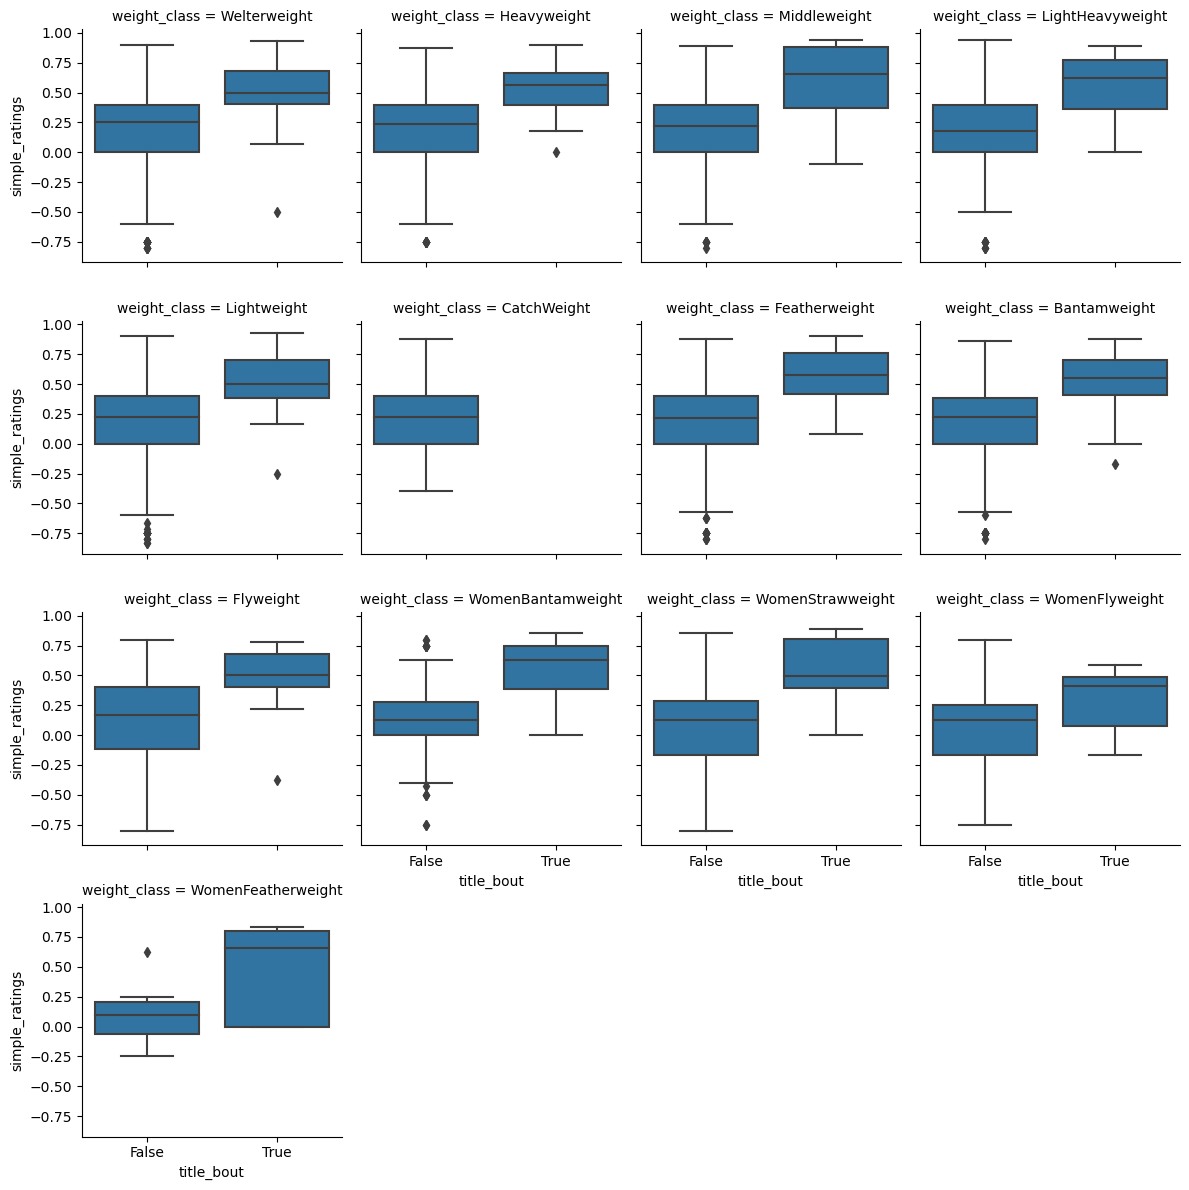

In [8]:
g = sns.FacetGrid(data = df_ratings[(df_ratings["n_fights"]>2)&(df_ratings["date"]>"2008")], col="weight_class", col_wrap=4)
g.map(sns.boxplot,"title_bout", "simple_ratings")

We can see that in all weight classes, fighters in a title bout tend to have higher ratings than fighters in regular fights.

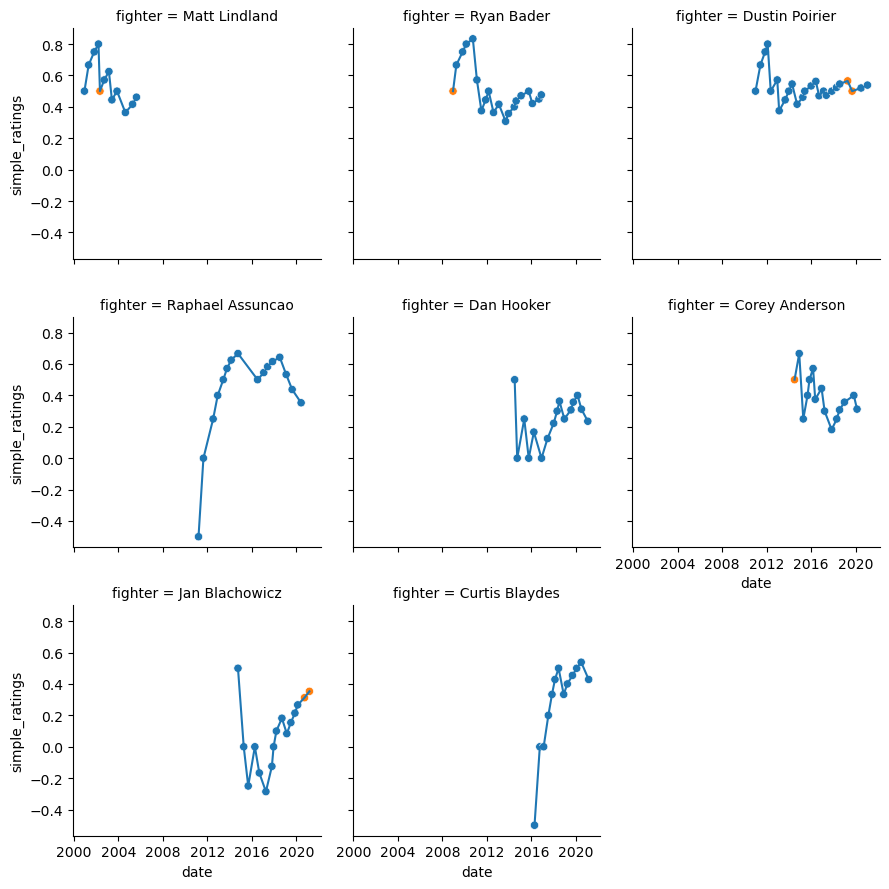

In [9]:
df = df_ratings.loc[df_ratings["fighter"].isin(np.random.choice(df_ratings.loc[df_ratings["n_fights"]>10,"fighter"].unique(), 9))]
g = sns.FacetGrid(data=df, col="fighter", col_wrap=3)
g.map(sns.lineplot,"date", "simple_ratings")
g.map(sns.scatterplot,"date", "simple_ratings", "title_bout")

In general title fights happen when the fighter is at a peak of rating

In [10]:
def convert_simpleRatingsToRanks(df_ratings, d):
    df = df_ratings.loc[df_ratings["date"]<=d].groupby("fighter").agg({"date":"max"}).reset_index()
    df = pd.merge(df, df_ratings[["fighter", "date", "simple_ratings"]], how="left", left_on=["fighter", "date"], right_on=["fighter", "date"])
    df = df.groupby("fighter").agg({"date":"last", "simple_ratings":"last"}).reset_index()
    df["rank"] = df["simple_ratings"].rank(ascending=False)
    df = df.drop(columns=["simple_ratings"])
    return df

df_wld_ranks = pd.concat([convert_simpleRatingsToRanks(df_ratings, d) for d in sample_dates])

## Pagerank rating

In [11]:
# preprocess df_fights to make it suitable for graph creation

def preprocess_draws(df_fights):
    df = df_fights.loc[df_fights["Winner"]=="Draw", ["R_fighter", "B_fighter", "date"]].copy().rename(columns={"R_fighter":"Winner", "B_fighter":"Loser"})
    df = pd.concat([df, df.rename(columns={"Loser":"Winner", "Winner":"Loser"})]).reset_index(drop=True)
    df["weight"] = 0.5
    return df

def preprocess_winsAndLosses(df_fights):
    df = df_fights.loc[df_fights["Winner"]!="Draw"].copy().rename(columns={"Winner":"Winner_RB"}).copy()
    df["Winner"] = df.apply(lambda u : u["R_fighter"] if u["Winner_RB"]=="Red" else u["B_fighter"], axis=1)
    df["Loser"] = df.apply(lambda u : u["R_fighter"] if u["Winner_RB"]=="Blue" else u["B_fighter"], axis=1)
    df["weight"] = 1
    df = df[["Winner", "Loser", "date", "weight"]].reset_index(drop=True)
    return df

def preprocess_df_fights(df_fights):
    df_draws = preprocess_draws(df_fights)
    df_wins_losses = preprocess_winsAndLosses(df_fights)
    return pd.concat([df_draws, df_wins_losses]).reset_index(drop=True)

def create_contactNetwork(df_preprocessed, start_date=None, end_date=None):
    if start_date is None:
        start_date = df_preprocessed["date"].min()
    if end_date is None:
        end_date = df_preprocessed["date"].max()
    df = df_preprocessed.loc[(df_preprocessed["date"] >= start_date) & (df_preprocessed["date"] <= end_date)].copy()
    df["date"] = df["date"].astype(str)
    return nx.from_pandas_edgelist(df, source="Loser", target="Winner", edge_attr=["date", "weight"], create_using=nx.DiGraph())

In [12]:
df_preprocessed = preprocess_df_fights(df_fights)
G = create_contactNetwork(df_preprocessed)
nx.set_node_attributes(G, {k:{"pr":v} for k,v in nx.pagerank(G).items()})
nx.write_gexf(G, "gephi_viz/ufc_network.gexf")

In [13]:
list_pr = []
for d in sample_dates:
    G = create_contactNetwork(df_preprocessed, end_date=d)
    list_pr.append(pd.Series(nx.pagerank(G), name=d))
df_pr = pd.concat([pd.DataFrame(G.nodes, columns=["fighter"]).set_index("fighter")] + list_pr, axis=1)

In [14]:
df_pr_ranks = df_pr.rank(ascending=False, axis=0).reset_index().melt(id_vars="index").dropna(subset="value").rename(columns={"index":"fighter", "variable":"date", "value":"rank"})
df_pr_ranks["date"] = pd.to_datetime(df_pr_ranks["date"])
df_pr_ranks

,fighter,date,rank
0,Manvel Gamburyan,2008-01-01,259.0
1,Dennis Siver,2008-01-01,275.0
5,Yves Edwards,2008-01-01,45.0
6,Melvin Guillard,2008-01-01,59.0
12,Pat Healy,2008-01-01,415.0
...,...,...,...
8094,Alberta Cerra Leon,2014-01-01,944.0
8095,Robert Lucarelli,2014-01-01,944.0
8096,David Levicki,2014-01-01,944.0
8097,Ray Wizard,2014-01-01,944.0


## Credible PageRank rating

### Reverse PageRank

In [15]:
def compute_judgesCredibility(G, list_fighters, ego=0., credibility_damping_factor=0.85):
    """Compute the credibility values for all nodes in the network

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        ego (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    l = []
    for fighter in list_fighters:
        G_fighter = G.copy().to_undirected()
        G_fighter.remove_nodes_from([x for x in list_fighters if x != fighter])
        d = nx.pagerank(G_fighter, personalization={fighter:1}, alpha=credibility_damping_factor, max_iter=10000)
        d.pop(fighter)
        s = pd.Series(d, name=fighter)
        l.append(s)
    df = pd.concat(l, axis=1)

# compute a hadamard product to have an aggregated credibility by node in the graph
    df["credibility"] = df.product(axis=1)
    df["credibility"] = df["credibility"]/(df["credibility"].max())

# add row for each fight in list_fighters since they were missing
    max_credibility = df["credibility"].max()
    for fighter in list_fighters:
        row = {fighter:df[fighter].max()*ego, "credibility":max_credibility*ego}
        for opponent in [x for x in list_fighters if x != fighter]:
            row[opponent] = 0
        df.loc[fighter] = row
    return df

# add nodes attributes to original G : global and marginal credibilities
def add_credibilityToNetwork(df, G):
    G_res = G.copy()
    for col in df.columns:
        d = dict(df[col])
        nx.set_node_attributes(G_res, {k:{col:v} for k,v in d.items()})
    return G_res

def get_relativeStrength(G, list_fighters, damping_factor=0.85):
    pr = nx.pagerank(G, personalization=nx.get_node_attributes(G, "credibility"), alpha=damping_factor, max_iter=10000)
    return pd.Series(pr).loc[list_fighters]

def compute_relativeStrength(G, list_fighters, ego=0.):
    """Compute the strength of nodes in list_fighters

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        ego (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    df = compute_judgesCredibility(G, list_fighters, ego)
    G = add_credibilityToNetwork(df, G)
    return get_relativeStrength(G, list_fighters), G

#### Example: Amanda Nunes vs Cat Zingano

Amanda Nunes is definitely the best fighter of the two. However, Nunes lost against Zingano. This is known as an upset (= an unexpected loss happens). This example is interesting because it showcases the role of the ego parameter. In our case Nunes vs Zingano, a high ego parameter should results in more importance of the fight between the two. \
A few interesting points about the ego parameter:
- ego is a relative parameter that is scaled on the highest credible judge
- an ego value of 0 means the final PR starts with no seed on competing nodes
- an ego value of 1 means the final PR starts with a seed on each competing node equal to the one on the most credible judge (ie competing node "rate themselves" as much as the most credible judge)

In [16]:
# demo # sourcery skip: merge-list-append, merge-list-appends-into-extend, merge-list-extend

list_fighters = []
list_fighters.append("Cat Zingano")
list_fighters.append("Amanda Nunes")

EGO = 0  # ego is the hyperparameter that determines the balance between the fighter's own importance and their judge's importance  

df_preprocessed = preprocess_df_fights(df_fights)
G = create_contactNetwork(df_preprocessed)

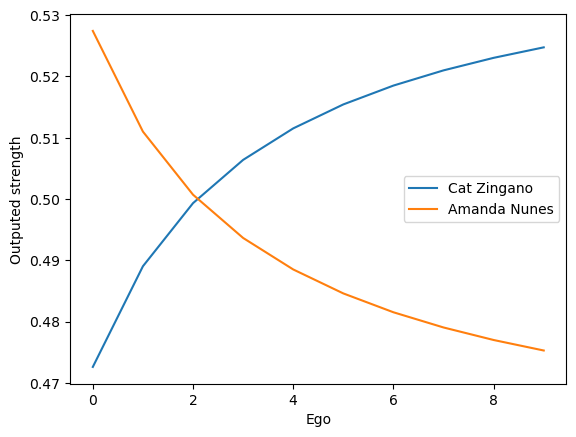

In [17]:
list_ego = list(range(10))
df = pd.concat([compute_relativeStrength(G, list_fighters, ego=e)[0] for e in list_ego], axis=1)
for f in list_fighters:
    plt.plot(list_ego, (df/df.sum(axis=0)).loc[f].values, label=f)
plt.xlabel("Ego")
plt.ylabel("Outputed strength")
plt.legend()

To compare, here is the same analysis for fighters Kamaru Usman and Leon Edwards. Usman has a better career and has beaten Edwards in a direct confrontation. No matter the ego parameter, Usman comes out on top which seems appropriate

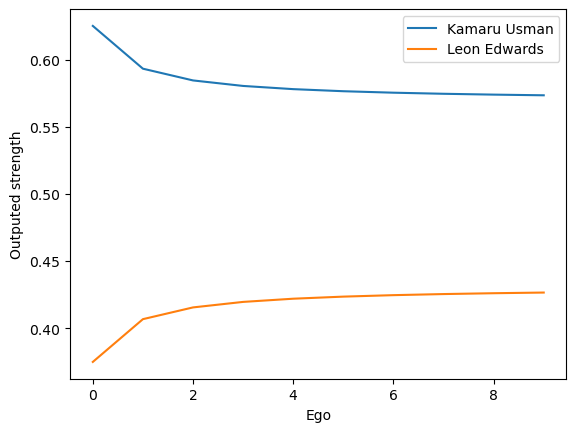

In [18]:
# demo # sourcery skip: merge-list-append, merge-list-appends-into-extend, merge-list-extend

list_fighters = []
list_fighters.append("Kamaru Usman")
list_fighters.append("Leon Edwards")

G = create_contactNetwork(df_preprocessed)
list_ego = list(range(10))
df = pd.concat([compute_relativeStrength(G, list_fighters, ego=e)[0] for e in list_ego], axis=1)
for f in list_fighters:
    plt.plot(list_ego, (df/df.sum(axis=0)).loc[f].values, label=f)
plt.xlabel("Ego")
plt.ylabel("Outputed strength")
plt.legend()

#### Small synthetic examples

In [19]:
list_fighters = [0,1]

*Disconnected network*

In this case, not judge can be identified because the nodes to be ranked are in different components.

,0,1,credibility
2,0.114865,0.000000,NaN
3,0.114865,0.000000,NaN
4,0.114865,0.000000,NaN
5,0.114865,0.000000,NaN
6,0.000000,0.459458,NaN
0,0.000000,0.000000,NaN
1,0.000000,0.000000,NaN


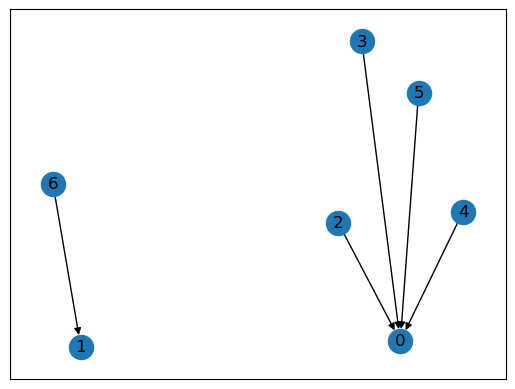

In [20]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
# s = get_relativeStrength(G, list_fighters)

*Strong bridge node*

Node 7 is identified as the only node able to make a judgment on the two nodes to be ranked. However, since it has won agaisnt both, it is not possible to make a decision.

,0,1,credibility
2,0.091892,0.000000,0.0
3,0.091892,0.000000,0.0
4,0.091892,0.000000,0.0
5,0.091892,0.000000,0.0
6,0.000000,0.229729,0.0
7,0.091892,0.229729,1.0
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0


Strengths :


0    0.0
1    0.0
dtype: float64

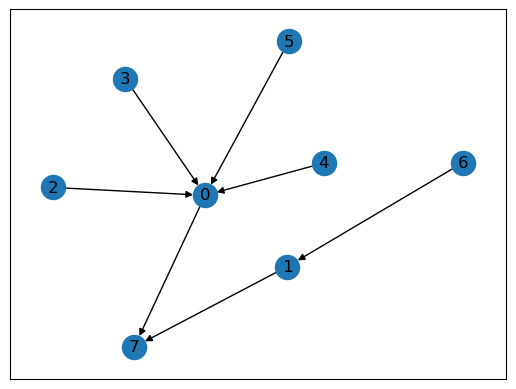

In [21]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            ,[1,7]
            ,[0,7]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters)
print("Strengths :")
display(s)

*Weak bridge node*
Same situation as before except this time the bridge give a positive strength to each node to be rank since it was beaten by both.

,0,1,credibility
2,0.091892,0.000000,0.0
3,0.091892,0.000000,0.0
4,0.091892,0.000000,0.0
5,0.091892,0.000000,0.0
6,0.000000,0.229729,0.0
7,0.091892,0.229729,1.0
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0


Strengths :


0    0.229729
1    0.229729
dtype: float64

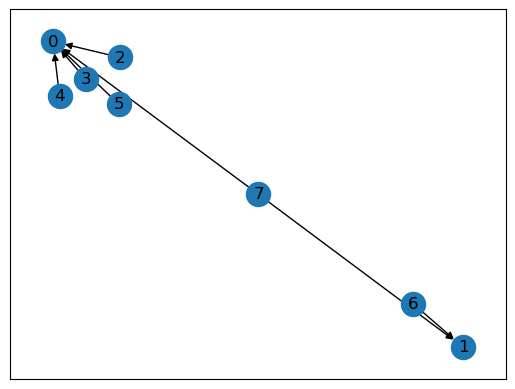

In [22]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            ,[7,1]
            ,[7,0]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters)
print("Strengths :")
display(s)

*Decisive bridge node*

A bridge node was beaten by node 1 and won against node 2. In this situation node 1 can be determined as the strongest node of the two.

,0,1,credibility
2,0.091892,0.000000,0.0
3,0.091892,0.000000,0.0
4,0.091892,0.000000,0.0
5,0.091892,0.000000,0.0
6,0.000000,0.229729,0.0
7,0.091892,0.229729,1.0
0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0


Strengths :


0    0.000000
1    0.459458
dtype: float64

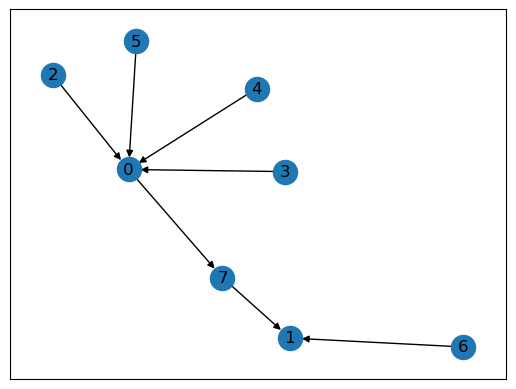

In [23]:
list_edge = ([2,0]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,1]
            ,[7,1]
            ,[0,7]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters)
print("Strengths :")
display(s)

Bridge and longer bridge \
<mark>Does it work yet?</mark> : <span style="color:red"> ? add the constraint that a short bridge one way and a longer bridge the other way should be in favor of the shortest bridge. That is to say if A beats Red but is beaten by Blue it means that Blue should be stronger than Red with more confidence than if A beats Red, but is beaten by B who is beaten by Blue / Or is it true ? A chain of beaten by might just mean there is a lot more distance between the two competing nodes. </span><span style="color:blue"> the damping factor for the final pr could be a parameter than enable us to adjust our confidence in long chains </span> / <span style="color:red"> Problem with bridge 1 nodes one way and bridge 2 nodes return ? </span>

,0,1,credibility
7,0.159121,0.159121,1.000000
8,0.019966,0.209763,0.165415
9,0.046981,0.119159,0.221103
10,0.070608,0.070608,0.196906
11,0.119159,0.046981,0.221103
12,0.209763,0.019966,0.165415
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000


Strengths :


0    0.008668
1    0.045773
dtype: float64

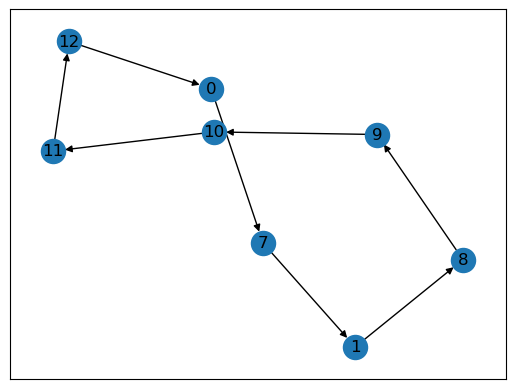

In [24]:
list_edge = (
            [7,1]
            ,[0,7]
            ,[1,8]
            ,[8,9]
            ,[9,10]
            ,[10,11]
            ,[11,12]
            ,[12,0]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G)
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters, damping_factor=0.1)
print("Strengths :")
display(s)

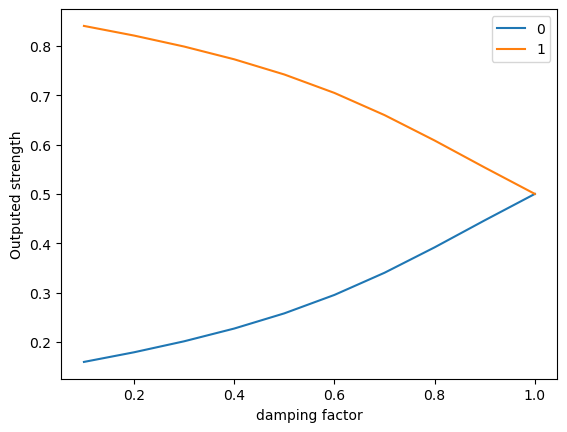

In [25]:
list_edge = (
            [7,1]
            ,[0,7]
            ,[1,8]
            ,[8,9]
            ,[9,10]
            ,[10,11]
            ,[11,12]
            ,[12,0]
            )
G = nx.DiGraph(list_edge)
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)

list_final_pr_damping = np.linspace(0,1,11)
df = pd.concat([get_relativeStrength(G, list_fighters, damping_factor=a) for a in list_final_pr_damping], axis=1)
for f in list_fighters:
    plt.plot(list_final_pr_damping, (df/df.sum(axis=0)).loc[f].values, label=f)
plt.xlabel("damping factor")
plt.ylabel("Outputed strength")
plt.legend()

Victories advantage on a plateau \
In this case, there is a clique of 3 players that have each won and lost against each other (nodes 2, 3 and 4). 0 has beaten one of them and 1 has won against two. Both 0 and 1 did not suffer a loss. As it designed, the algorithm will rank 1 higher than 0 which makes sense if you consider that 1 has more experience and victories against the judges. However we could also want to rank 0 and 1 equivalently.

,0,1,credibility
2,0.374641,0.153724,1.000000
3,0.184605,0.271276,0.869561
4,0.184605,0.271276,0.869561
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000


Strengths :


0    0.011678
1    0.020580
dtype: float64

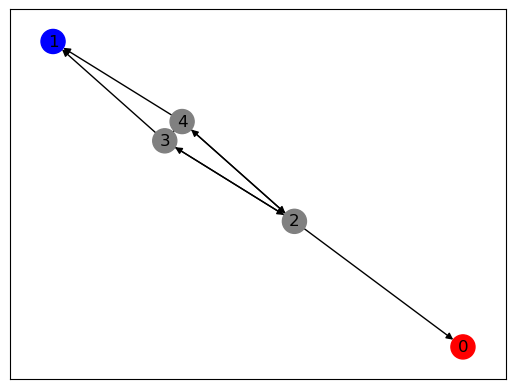

In [26]:
list_edge = (
            [2,0]
            ,[2,3]
            ,[3,2]
            ,[3,1]
            ,[2,4]
            ,[4,2]
            ,[4,1]
            ,[3,4]
            ,[4,3]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G, node_color=['Red' if node == 0 else 'Blue' if node==1 else "gray" for node in G] )
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters, damping_factor=0.1)
print("Strengths :")
display(s)

**Experience-competence tradeoff**

Victories advantage on a inclined plateau \
Now, nodes inbetween 0 and 1 are not an undirected clique. 2 beats 3 but is not beaten by it. This means that 2 is probably better than 3 and 4. However, when executing the algorithm, 1 comes out as better than 0, which means that in this case the algorithm values more beating two weak opponents vs beating one stronger opponent. This choice is arbitrary. The problem is that at this point there is no parameter in the algorithm that enable us to adjust this choice. Indeed, no matter the damping factor, the answer is always 1 higher than 2.



More formally, the problem can be phrased like this : \
Given a clique of n nodes in which all nodes are on par (1 win, 1 loss) with each other except one node who has an advantage on the others. If 0 has beaten this node only and 1 has beaten all others (0 has 1 fight, 1 has n-1 fights), there should be a tunable parameter that makes the algorithm answer 0 or 1 is better conditionnally on this parameter. This would be a way to include prior value system in the algorithm in a experience-competence tradeoff.

,0,1,credibility
2,0.374641,0.153724,1.000000
3,0.184605,0.271276,0.869561
4,0.184605,0.271276,0.869561
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000


Strengths :


0    0.127454
1    0.152609
dtype: float64

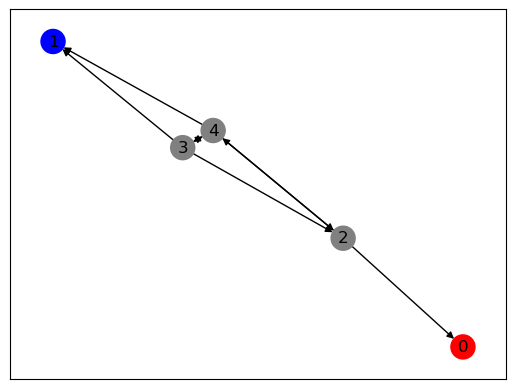

In [27]:
list_edge = (
            [2,0]
            # ,[2,3]
            ,[3,2]
            ,[3,1]
            ,[2,4]
            ,[4,2]
            ,[4,1]
            ,[3,4]
            ,[4,3]
            )
G = nx.DiGraph(list_edge)
nx.draw_networkx(G, node_color=['Red' if node == 0 else 'Blue' if node==1 else "gray" for node in G] )
df = compute_judgesCredibility(G, list_fighters, ego=EGO)
G = add_credibilityToNetwork(df, G)
display(df)
s = get_relativeStrength(G, list_fighters, damping_factor=0.99)
print("Strengths :")
display(s)

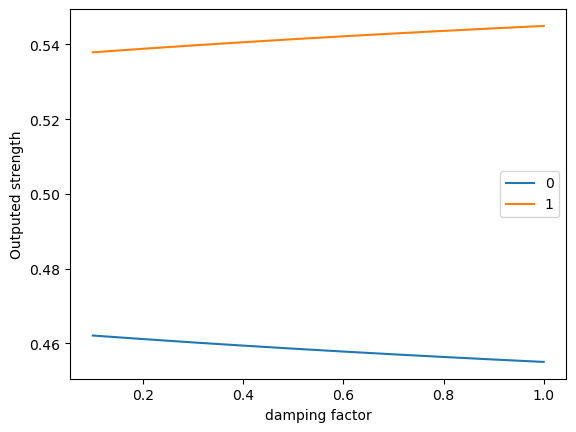

In [28]:
list_final_pr_damping = np.linspace(0,1,11)
df = pd.concat([get_relativeStrength(G, list_fighters, damping_factor=a) for a in list_final_pr_damping], axis=1)
for f in list_fighters:
    plt.plot(list_final_pr_damping, (df/df.sum(axis=0)).loc[f].values, label=f)
plt.xlabel("damping factor")
plt.ylabel("Outputed strength")
plt.legend()

#### Presentation example from beamer

In [29]:
list_edge = (
            [12,4]
            ,[2,4]
            ,[2,0]
            ,[3,12]
            ,[3,0]
            ,[4,0]
            ,[5,0]
            ,[6,0]
            ,[6,3]
            ,[0,7]
            ,[0,8]
            ,[7,9]
            ,[8,1]
            ,[9,1]
            ,[10,1]
            ,[11,10]
            ,[11,1]
            # ,[7,6]  # connects the two clusters
            )
G = nx.DiGraph(list_edge)

pos = nx.spring_layout(G.subgraph(set(G)))  # initialisation of position dict

pos[0] = [0,0]
pos[1] = [1,0]
pos[12] = [-0.5,0]
pos[2] = [-0.4, -0.25]
pos[3] = [-0.4, 0.25]
pos[4] = [-0.25, 0]
pos[5] = [-0.25, -.35]
pos[6] = [-0.15, 0.25]
pos[7] = [0.25, 0.15]
pos[8] = [0.25, -0.15]
pos[9] = [0.75, 0]
pos[10] = [1.15, -0.15]
pos[11] = [1.15, 0.15]

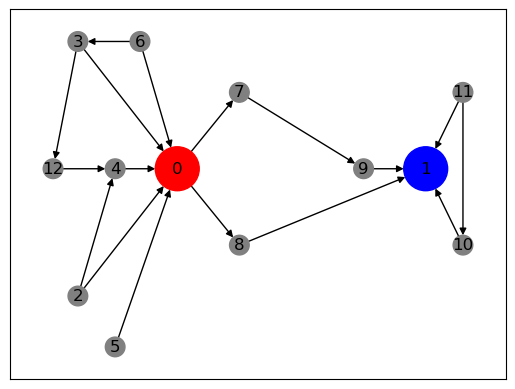

In [30]:
color_map = ['Red' if node == 0 else 'Blue' if node==1 else "gray" for node in G] 
nx.draw_networkx(G
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color=color_map)

In [31]:
df = compute_judgesCredibility(G, list_fighters, ego=EGO, credibility_damping_factor=0.5)

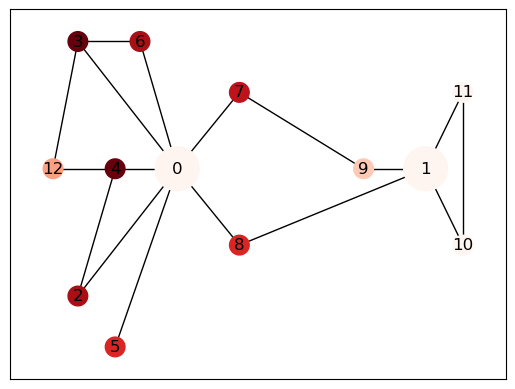

In [32]:
nx.draw_networkx(G.to_undirected()
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color= df.loc[list(G.nodes), 0].values
                 ,cmap=plt.get_cmap('Reds')
                 )

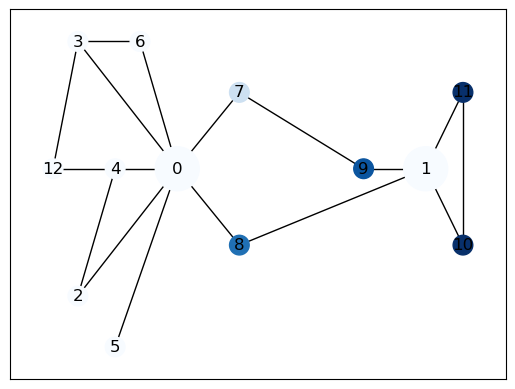

In [33]:
nx.draw_networkx(G.to_undirected()
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color= df.loc[list(G.nodes), 1].values
                 ,cmap=plt.get_cmap('Blues')
                 )

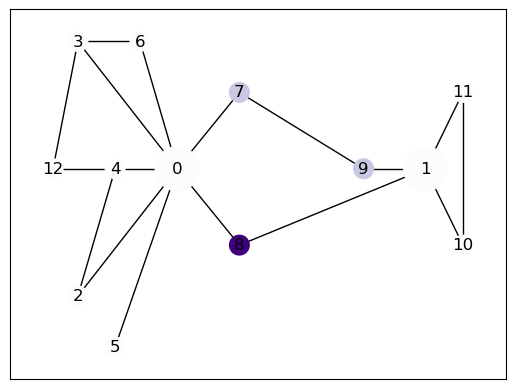

In [35]:
nx.draw_networkx(G.to_undirected()
                 ,pos=pos
                 ,node_size=[1000 if x in (0,1) else 200 for x in list(G.nodes)]
                 ,node_color= df.loc[list(G.nodes), "credibility"].values
                 ,cmap=plt.get_cmap('Purples')
                 )

### Walk Index (ongoing)

1. Récupérer tous les paths entre 0 et 1
2. Décomposer les paths pour avoir les paths non plus entre 0 et 1 mais entre 0 et tous les noeuds distincts rencontrés et 1 et tous les noeuds distincts rencontrés
3. Compter pour chaque noeud rencontré le nombre de chemin de longueur l à 0 et à 1

In [34]:
df_preprocessed = preprocess_df_fights(df_fights)
G = create_contactNetwork(df_preprocessed)

In [35]:
fighter0 = "Leon Edwards"
fighter1 = "Kamaru Usman"
list_path = list(nx.all_simple_paths(G, fighter0, fighter1, cutoff=5))

In [36]:
list_split0 = []
list_split1 = []
for l in list_path:
    n = len(l)
    for i in range(1, n-1):
        sublist0 = l[:i+1]
        sublist1 = l[i:]
        if sublist0 not in list_split0:
            list_split0.append(sublist0)
        if sublist1 not in list_split1:
            list_split1.append(sublist1)

In [37]:
list_split1

[['Belal Muhammad',
  'Geoff Neal',
  'Stephen Thompson',
  'Tyron Woodley',
  'Kamaru Usman'],
 ['Geoff Neal', 'Stephen Thompson', 'Tyron Woodley', 'Kamaru Usman'],
 ['Stephen Thompson', 'Tyron Woodley', 'Kamaru Usman'],
 ['Tyron Woodley', 'Kamaru Usman'],
 ['Belal Muhammad',
  'Vicente Luque',
  'Stephen Thompson',
  'Tyron Woodley',
  'Kamaru Usman'],
 ['Vicente Luque', 'Stephen Thompson', 'Tyron Woodley', 'Kamaru Usman'],
 ['Belal Muhammad',
  'Alan Jouban',
  'Gunnar Nelson',
  'Gilbert Burns',
  'Kamaru Usman'],
 ['Alan Jouban', 'Gunnar Nelson', 'Gilbert Burns', 'Kamaru Usman'],
 ['Gunnar Nelson', 'Gilbert Burns', 'Kamaru Usman'],
 ['Gilbert Burns', 'Kamaru Usman'],
 ['Belal Muhammad',
  'Alan Jouban',
  'Gunnar Nelson',
  'Demian Maia',
  'Kamaru Usman'],
 ['Alan Jouban', 'Gunnar Nelson', 'Demian Maia', 'Kamaru Usman'],
 ['Gunnar Nelson', 'Demian Maia', 'Kamaru Usman'],
 ['Demian Maia', 'Kamaru Usman'],
 ['Belal Muhammad', 'Alan Jouban', 'Warlley Alves', 'Kamaru Usman'],
 ['Alan

In [38]:
d0 = {}
d1 = {}
for l in list_path:
    n = len(l)
    for i in range(1, n-1):
        if l[i] in d0:
            d0[l[i]].append(i)
            d1[l[i]].append(n-i)
        else:
            d0[l[i]] = []
            d1[l[i]] = []

## Link direction prediction
To quantify the results, we can set up a prediction task. The task will be to predict the outcome of fights given all previous fight results. This amounts to predicting the direction of new edges arriving in the network. With Vanilla PR the results are more or less equivalent to chance as prediction is correct in just 50.6% of cases. The addition of a time based recency increase the results to 52.4%.
While results of prediction are poor, predicting winning chances is not what is targeted by the PageRank. What is scored by PR approaches is closer to "who has had the best carreer so far?"

Text(0.5, 1.0, 'Number of fights by period of 30 days (smoothed)')

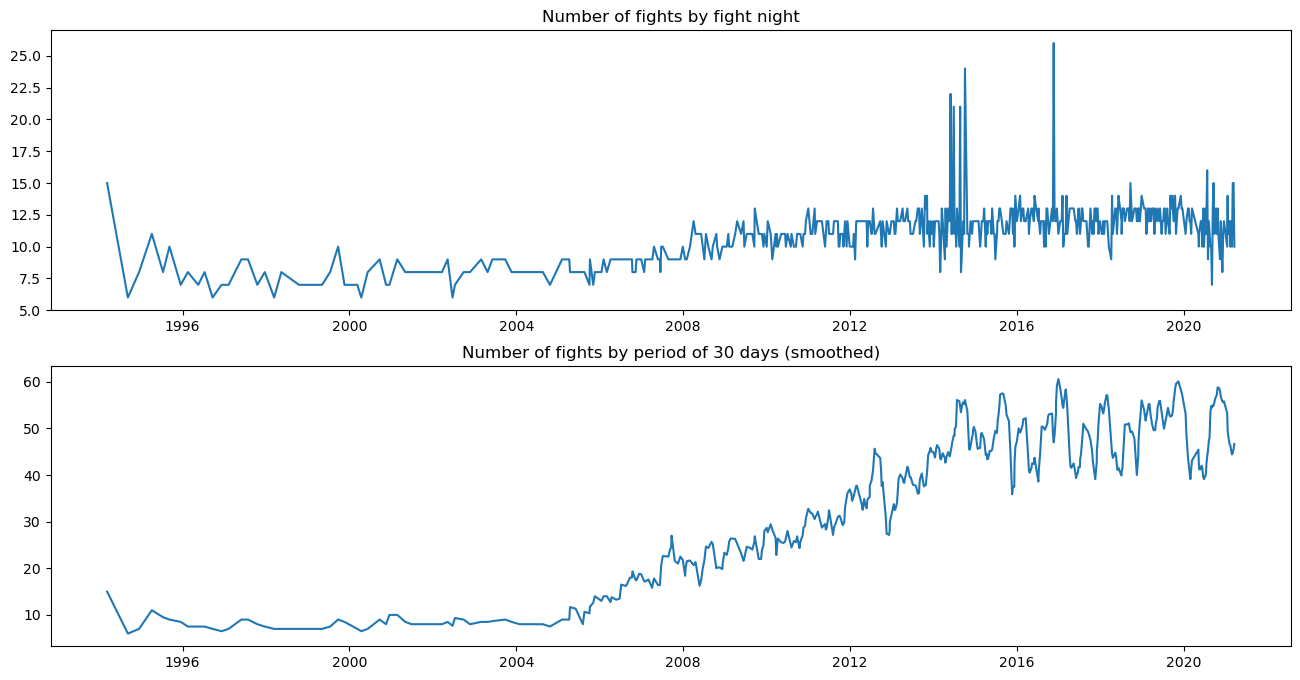

In [39]:
df_preprocessed = preprocess_df_fights(df_fights)
fig, ax = plt.subplots(2,1, figsize=(16,8))
ax[0].plot(df_preprocessed.groupby("date").size())
ax[0].set_title("Number of fights by fight night")
ax[1].plot(df_preprocessed.groupby("date").size().rolling("30D").agg(sum).rolling("100D").agg("mean"))
ax[1].set_title("Number of fights by period of 30 days (smoothed)")

We can see that the number of fights by fight night does not vary much whereas the number of fights by period of 30 days dramatically increased in the period 2006-2014. This can also be seen as the frequency of the curve is increasing on the top plot.

### PageRank

In [40]:
df_pred = preprocess_df_fights(df_fights)
list_dates = np.sort(df_pred["date"].unique())
for i, date in enumerate(list_dates[:-1]):
    G = create_contactNetwork(df_pred, end_date=date)  # pas optimisé
    next_date = list_dates[i+1]
    pr = nx.pagerank(G)
    df_pred.loc[df_pred["date"]==next_date, "pr_winner"] = df_pred.loc[df_pred["date"]==next_date, "Winner"].map(pr)
    df_pred.loc[df_pred["date"]==next_date, "pr_loser"] = df_pred.loc[df_pred["date"]==next_date, "Loser"].map(pr)

In [41]:
df = df_pred.dropna(subset=["pr_winner", "pr_loser"])
display(df.head())
(df["pr_winner"]>df["pr_loser"]).sum()/len(df)

,Winner,Loser,date,weight,pr_winner,pr_loser
0,Leon Edwards,Belal Muhammad,2021-03-13,0.5,0.002019,0.001165
1,Eryk Anders,Darren Stewart,2021-03-13,0.5,0.000385,0.000375
2,Montana De La Rosa,Mayra Bueno Silva,2021-02-27,0.5,0.000321,0.000271
3,Deiveson Figueiredo,Brandon Moreno,2020-12-12,0.5,0.002445,0.001986
4,Da-Un Jung,Sam Alvey,2020-10-24,0.5,0.000253,0.001278


0.5061813186813187

### PageRank with recency

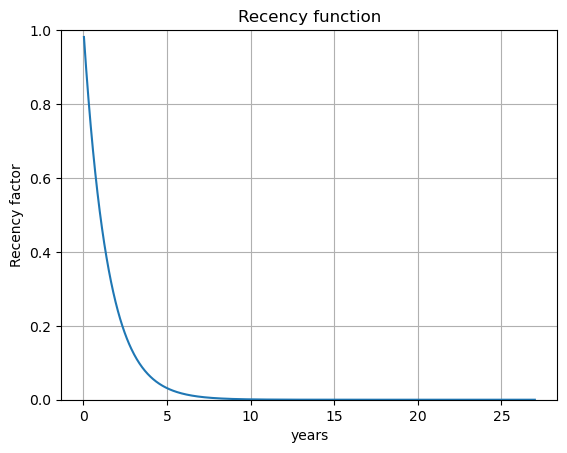

In [42]:
# Define the function
def compute_recencyFactor(x, a=1/2):
    return a**x

# Generate x values from -10 to 10 (excluding zero)
x = np.linspace(0, 27, 1000)
x = np.delete(x, np.where(x == 0))  # Remove zero from the array

# Calculate y values
y = compute_recencyFactor(x)

# Plot the function
plt.plot(x, y)
plt.xlabel('years')
plt.ylabel('Recency factor')
plt.title('Recency function')
plt.grid(True)
plt.ylim(0,1)
plt.show()

In [49]:
df_pred = preprocess_df_fights(df_fights)
df_pred["raw_weight"] = df_pred["weight"]
list_dates = np.sort(df_pred["date"].unique())
for i, date in enumerate(list_dates[:-1]):
    df_pred["weight"] = ((date - df_pred["date"])/ np.timedelta64(1, 'Y')).apply(lambda u : compute_recencyFactor(u, a=0.5)) * df_pred["raw_weight"]
    G = create_contactNetwork(df_pred, end_date=date)  # pas optimisé
    next_date = list_dates[i+1]
    pr = nx.pagerank(G)
    df_pred.loc[df_pred["date"]==next_date, "pr_winner"] = df_pred.loc[df_pred["date"]==next_date, "Winner"].map(pr)
    df_pred.loc[df_pred["date"]==next_date, "pr_loser"] = df_pred.loc[df_pred["date"]==next_date, "Loser"].map(pr)

df = df_pred.dropna(subset=["pr_winner", "pr_loser"])
(df["pr_winner"]>df["pr_loser"]).sum()/len(df)

0.5238095238095238

### Credible PageRank

In [43]:
def have_sharedInfo(G, fighter0, fighter1):
    try :
        return nx.has_path(G.to_undirected(), fighter0, fighter1)
    except(nx.exception.NodeNotFound):
        return False
    
def f_applyComputeRelativeStrength(row, G):
    strengths = compute_relativeStrength(G, [row["Winner"], row["Loser"]], ego=0)[0]
    pr_winner = strengths[row["Winner"]]
    pr_loser = strengths[row["Loser"]]
    return pd.Series([pr_winner, pr_loser])

In [180]:
df_pred = preprocess_df_fights(df_fights)
list_dates = np.sort(df_pred["date"].unique())
for i, date in enumerate(list_dates[:-1]):
    G = create_contactNetwork(df_pred, end_date=date)
    next_date = list_dates[i+1]
    df_pred.loc[df_pred["date"]==next_date, "have_shared_info"] = df_pred.loc[df_pred["date"]==next_date].apply(lambda u : have_sharedInfo(G.to_undirected(), u["Winner"], u["Loser"]), axis=1)
    mask_credible_pr = (df_pred["date"]==next_date)&(df_pred["have_shared_info"])
    if mask_credible_pr.any():
        df_pred.loc[mask_credible_pr, ["pr_winner", "pr_loser"]] = df_pred.loc[mask_credible_pr].apply(lambda u : f_applyComputeRelativeStrength(u, G), axis=1).values
df = df_pred.dropna()
(df["pr_winner"]>df["pr_loser"]).sum()/len(df)

0.5263424518743668

### Credible PageRank with recency

In [181]:
df_pred = preprocess_df_fights(df_fights)
df_pred["raw_weight"] = df_pred["weight"]
list_dates = np.sort(df_pred["date"].unique())
for i, date in enumerate(list_dates[:-1]):
    df_pred["weight"] = ((date - df_pred["date"])/ np.timedelta64(1, 'Y')).apply(lambda u : compute_recencyFactor(u, a=0.5)) * df_pred["raw_weight"]
    G = create_contactNetwork(df_pred, end_date=date)
    next_date = list_dates[i+1]
    df_pred.loc[df_pred["date"]==next_date, "have_shared_info"] = df_pred.loc[df_pred["date"]==next_date].apply(lambda u : have_sharedInfo(G.to_undirected(), u["Winner"], u["Loser"]), axis=1)
    mask_credible_pr = (df_pred["date"]==next_date)&(df_pred["have_shared_info"])
    if mask_credible_pr.any():
        df_pred.loc[mask_credible_pr, ["pr_winner", "pr_loser"]] = df_pred.loc[mask_credible_pr].apply(lambda u : f_applyComputeRelativeStrength(u, G), axis=1).values
df = df_pred.dropna()
(df["pr_winner"]>df["pr_loser"]).sum()/len(df)

0.5425531914893617

## Ranking comparison
Perform one loop to compute pr for winners and losers for :
- PR
- PR with recency
- Credible PR
- Credible PR with recency

In [182]:
df_pred = preprocess_df_fights(df_fights)
df_pred["raw_weight"] = df_pred["weight"]
list_dates = np.sort(df_pred["date"].unique())
for i, date in enumerate(list_dates[:-1]):
    next_date = list_dates[i+1]
    df_pred["weight"] = df_pred["raw_weight"]
    
    # without recency
    
    G = create_contactNetwork(df_pred, end_date=date)
    
    # PR
    pr = nx.pagerank(G)
    df_pred.loc[df_pred["date"]==next_date, "pr_winner"] = df_pred.loc[df_pred["date"]==next_date, "Winner"].map(pr)
    df_pred.loc[df_pred["date"]==next_date, "pr_loser"] = df_pred.loc[df_pred["date"]==next_date, "Loser"].map(pr)
    
    # CPR
    df_pred.loc[df_pred["date"]==next_date, "have_shared_info"] = df_pred.loc[df_pred["date"]==next_date].apply(lambda u : have_sharedInfo(G.to_undirected(), u["Winner"], u["Loser"]), axis=1)
    mask_credible_pr = (df_pred["date"]==next_date)&(df_pred["have_shared_info"])
    if mask_credible_pr.any():
        df_pred.loc[mask_credible_pr, ["cpr_winner", "cpr_loser"]] = df_pred.loc[mask_credible_pr].apply(lambda u : f_applyComputeRelativeStrength(u, G), axis=1).values
    
    # with recency
    
    df_pred["weight"] = ((date - df_pred["date"])/ np.timedelta64(1, 'Y')).apply(lambda u : compute_recencyFactor(u, a=0.5)) * df_pred["raw_weight"]
    G = create_contactNetwork(df_pred, end_date=date)
    
    # PR
    pr = nx.pagerank(G)
    df_pred.loc[df_pred["date"]==next_date, "pr_recency_winner"] = df_pred.loc[df_pred["date"]==next_date, "Winner"].map(pr)
    df_pred.loc[df_pred["date"]==next_date, "pr_recency_loser"] = df_pred.loc[df_pred["date"]==next_date, "Loser"].map(pr)

    
    # CPR
    if mask_credible_pr.any():
        df_pred.loc[mask_credible_pr, ["cpr_recency_winner", "cpr_recency_loser"]] = df_pred.loc[mask_credible_pr].apply(lambda u : f_applyComputeRelativeStrength(u, G), axis=1).values

# df_pred.to_csv("data/df_pred_UFC.csv")

In [57]:
df_pred = pd.read_csv("data/df_pred_UFC.csv")
mask_pr = (~(df_pred["pr_winner"].isna())) & (~(df_pred["pr_loser"].isna()))
mask_cpr = (~(df_pred["cpr_winner"].isna())) & (~(df_pred["cpr_loser"].isna()))

res_pr = (df_pred.loc[mask_pr, "pr_winner"]>df_pred.loc[mask_pr, "pr_loser"]).sum() / len(df_pred.loc[mask_pr])
res_pr_recency = (df_pred.loc[mask_pr, "pr_recency_winner"]>df_pred.loc[mask_pr, "pr_recency_loser"]).sum() / len(df_pred.loc[mask_pr])
res_cpr = (df_pred.loc[mask_cpr, "cpr_winner"]>df_pred.loc[mask_cpr, "cpr_loser"]).sum() / len(df_pred.loc[mask_cpr])
res_cpr_recency = (df_pred.loc[mask_cpr, "cpr_recency_winner"]>df_pred.loc[mask_cpr, "cpr_recency_loser"]).sum() / len(df_pred.loc[mask_cpr])
res_pr_cprSubset = (df_pred.loc[mask_cpr, "pr_winner"]>df_pred.loc[mask_cpr, "pr_loser"]).sum() / len(df_pred.loc[mask_cpr])
res_pr_recency_cprSubset = (df_pred.loc[mask_cpr, "pr_recency_winner"]>df_pred.loc[mask_cpr, "pr_recency_loser"]).sum() / len(df_pred.loc[mask_cpr])
# mask = (~(df_pred["pr_recency_winner"].isna())) & (~(df_pred["pr_recency_loser"].isna()))
# res_pr_recency = (df_pred.loc[mask, "pr_recency_winner"]>df_pred.loc[mask, "pr_recency_loser"]).sum() / len(df_pred.loc[mask])


print(f"""PR : {res_pr:.4f}\nPR (CPR subset): {res_pr_cprSubset:.4f}\nPR with recency: {res_pr_recency:.4f}\nCPR: {res_cpr:.4f}\nPR with recency (CPR subset): {res_pr_recency_cprSubset:.4f}\nCPR with recency: {res_cpr_recency:.4f}""")

PR : 0.5062
PR (CPR subset): 0.5114
PR with recency: 0.5238
CPR: 0.5263
PR with recency (CPR subset): 0.5304
CPR with recency: 0.5426


### Baseline

With the baseline $wins-losses$ ie in and out degree difference, we reach 80% accuracy on the whole dataset (no train nor test because there is no parameter ie no learning)

In [122]:
df_ratings["baseline_ratings"] = df_ratings["won_total"] - df_ratings["lost_total"]
df_ratings

,fighter,date,title_bout,weight_class,won,lost,draw,won_total,lost_total,draw_total,n_fights,simple_ratings,baseline_ratings
0,Sean Daugherty,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000,-1
1,Remco Pardoel,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000,-1
2,Orlando Wiet,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000,-1
3,Johnny Rhodes,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000,-1
4,Fred Ettish,1994-03-11,False,OpenWeight,False,True,False,0,1,0,1,-0.500000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12019,Derek Brunson,2021-03-20,False,Middleweight,True,False,False,13,5,0,18,0.421053,8
12020,Montel Jackson,2021-03-20,False,Bantamweight,True,False,False,4,2,0,6,0.285714,2
12021,Bruno Silva,2021-03-20,False,Flyweight,True,False,False,1,2,1,4,-0.200000,-1
12022,Trevin Giles,2021-03-20,False,Middleweight,True,False,False,5,2,0,7,0.375000,3


In [291]:
df = df_fights[["R_fighter",	"B_fighter", "date", "Winner"]].merge(
    df_ratings[["fighter","date","baseline_ratings"]].groupby(["fighter","date"]).agg({"baseline_ratings":"first"}).reset_index(), how="left", left_on=["R_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"baseline_ratings":"R_baseline_ratings"}).drop(columns="fighter").merge(
        df_ratings[["fighter","date","baseline_ratings"]].groupby(["fighter","date"]).agg({"baseline_ratings":"first"}).reset_index(), how="left", left_on=["B_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"baseline_ratings":"B_baseline_ratings"}).drop(columns="fighter")
df

,R_fighter,B_fighter,date,Winner,R_baseline_ratings,B_baseline_ratings
0,Adrian Yanez,Gustavo Lopez,2021-03-20,Red,2,-1
1,Trevin Giles,Roman Dolidze,2021-03-20,Red,3,1
2,Tai Tuivasa,Harry Hunsucker,2021-03-20,Red,2,-1
3,Cheyanne Buys,Montserrat Conejo,2021-03-20,Blue,-1,1
4,Marion Reneau,Macy Chiasson,2021-03-20,Blue,-1,4
...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,1994-03-11,Red,-1,-1
6008,Orlando Wiet,Robert Lucarelli,1994-03-11,Red,-1,-1
6009,Johnny Rhodes,David Levicki,1994-03-11,Red,-1,-1
6010,Patrick Smith,Ray Wizard,1994-03-11,Red,1,-1


In [292]:
pred = df.apply(lambda u :  "Red" if u["R_baseline_ratings"] > u["B_baseline_ratings"] else ("Blue" if u["R_baseline_ratings"] < u["B_baseline_ratings"] else "Draw"), axis=1)

In [293]:
(pred == df["Winner"]).sum() / len(pred)

0.8000665335994678

In [294]:
df["Winner_int"] = df["Winner"].map({"Red":1, "Draw":0, "Blue":-1})

<AxesSubplot:xlabel='R_baseline_ratings', ylabel='B_baseline_ratings'>

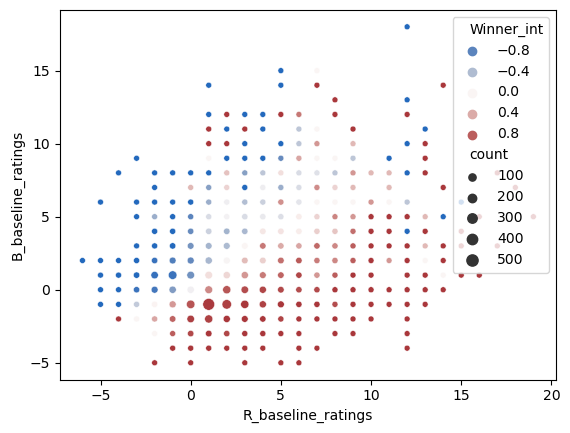

In [295]:
sns.scatterplot(
    data = df.groupby(["R_baseline_ratings", "B_baseline_ratings"]).agg({"R_baseline_ratings" : "count", "Winner_int":"mean"}).rename(columns={"R_baseline_ratings":"count"}).reset_index(),
    x="R_baseline_ratings", y="B_baseline_ratings", size="count", hue="Winner_int", palette=sns.color_palette("vlag", as_cmap=True))

### Display of simple ratings

In [261]:
df = df_fights[["R_fighter",	"B_fighter", "date", "Winner"]].merge(
    df_ratings[["fighter","date","simple_ratings"]].groupby(["fighter","date"]).agg({"simple_ratings":"first"}).reset_index(),
    how="left", left_on=["R_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"simple_ratings":"R_simple_ratings"}).drop(columns="fighter").merge(
        df_ratings[["fighter","date","simple_ratings"]].groupby(["fighter","date"]).agg({"simple_ratings":"first"}).reset_index(),
        how="left", left_on=["B_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"simple_ratings":"B_simple_ratings"}).drop(columns="fighter")

a_bins = np.linspace(-1,1,11)
df["digitized_B"] = np.digitize(df["B_simple_ratings"], bins=a_bins)
df["digitized_R"] = np.digitize(df["R_simple_ratings"], bins=a_bins)
df["digitized_Winner"] = df["Winner"].map({"Red":1, "Draw":0, "Blue":-1})
df = df[["digitized_B", "digitized_R", "digitized_Winner"]].groupby(["digitized_B", "digitized_R"]).agg({
    "digitized_Winner":["count", "mean"]}).droplevel(0, axis=1).reset_index()
df

,digitized_B,digitized_R,count,mean
0,2,3,2,1.000000
1,2,4,25,1.000000
2,2,5,12,1.000000
3,2,6,138,1.000000
4,2,7,101,1.000000
...,...,...,...,...
77,10,6,21,-1.000000
78,10,7,40,-1.000000
79,10,8,19,-0.947368
80,10,9,2,-1.000000


In [273]:
M_count = np.zeros((len(a_bins), len(a_bins)))
M_mean = np.zeros((len(a_bins), len(a_bins)))
for line in df.iterrows():
    M_count[int(line[1]["digitized_B"]), int(line[1]["digitized_R"])] = line[1]["count"]
    M_mean[int(line[1]["digitized_B"]), int(line[1]["digitized_R"])] = line[1]["mean"]

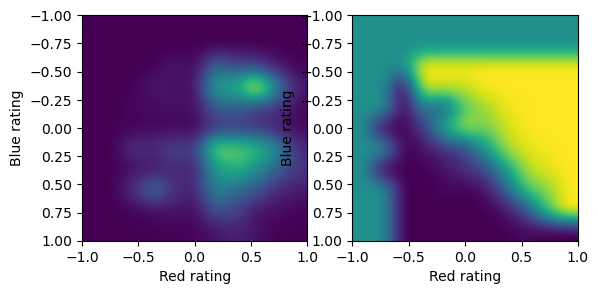

In [285]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(M_count,interpolation="quadric", extent=[-1,1,1,-1])
ax[0].set_xlabel("Red rating")
ax[0].set_ylabel("Blue rating")
ax[1].set_xlabel("Red rating")
ax[1].set_ylabel("Blue rating")
ax[1].imshow(M_mean,interpolation="quadric", extent=[-1,1,1,-1])

On the left plot, we can see that the Red fighter rating is on average higher. There are 4 distinguishable density areas:
1. low red rating, low blue rating : does not happen
2. low red, high blue rating : very rare
3. low blue, high red : frequent
4. high red high blue : frequent

So we understand that red is often the favorite and that high rated fighter fight more.

On the right plot, we see a clear boundary. This mean that there is a good correlation between the highest rating and the winning chances.

### Simple ratings function parameters optimization

With the function of two parameters taking into account wins, losses and draws and a gradient descent schema optimization we reach 84.5% accuracy on a random test set

In [413]:
df = df_fights[["R_fighter",	"B_fighter", "date", "Winner"]].merge(
    df_ratings[["fighter","date","won_total", "lost_total", "draw_total"]].groupby(["fighter","date"]).agg({"won_total":"first", "lost_total":"first", "draw_total":"first"}).reset_index(),
    how="left", left_on=["R_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"won_total":"R_won_total",
                      "lost_total":"R_lost_total",
                      "draw_total":"R_draw_total",
                      }).drop(columns="fighter").merge(
    df_ratings[["fighter","date","won_total", "lost_total", "draw_total"]].groupby(["fighter","date"]).agg({"won_total":"first", "lost_total":"first", "draw_total":"first"}).reset_index(),
    how="left", left_on=["B_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"won_total":"B_won_total",
                      "lost_total":"B_lost_total",
                      "draw_total":"B_draw_total",
                      }).drop(columns="fighter")
y= torch.tensor(df["Winner"].map({"Red":1, "Draw":0, "Blue":-1}), dtype=torch.float32)
X = torch.tensor(df[["R_won_total",	"R_lost_total",	"R_draw_total",	"B_won_total",	"B_lost_total",	"B_draw_total"]].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
df

,R_fighter,B_fighter,date,Winner,R_won_total,R_lost_total,R_draw_total,B_won_total,B_lost_total,B_draw_total
0,Adrian Yanez,Gustavo Lopez,2021-03-20,Red,2,0,0,1,2,0
1,Trevin Giles,Roman Dolidze,2021-03-20,Red,5,2,0,2,1,0
2,Tai Tuivasa,Harry Hunsucker,2021-03-20,Red,5,3,0,0,1,0
3,Cheyanne Buys,Montserrat Conejo,2021-03-20,Blue,0,1,0,1,0,0
4,Marion Reneau,Macy Chiasson,2021-03-20,Blue,5,6,1,5,1,0
...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,1994-03-11,Red,0,1,0,0,1,0
6008,Orlando Wiet,Robert Lucarelli,1994-03-11,Red,0,1,0,0,1,0
6009,Johnny Rhodes,David Levicki,1994-03-11,Red,0,1,0,0,1,0
6010,Patrick Smith,Ray Wizard,1994-03-11,Red,1,0,0,0,1,0


In [576]:
class WinLossDraw(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([1.]))
        self.t = torch.nn.Parameter(torch.tensor([1.]))

    def forward(self, x):
        x1, x2 = x[:, :3], x[:, 3:]
        w1, l1, d1 = x1[:,0], x1[:,1], x1[:,2]
        w2, l2, d2 = x2[:,0], x2[:,1], x2[:,2]
        a = (w1 - self.alpha*l1 +.5*d1 - 0.5*self.alpha*d1)/(w1+l1+d1+self.t) - (w2 - self.alpha*l2 +.5*d2 - 0.5*self.alpha*d2)/(w2+l2+d2+self.t)
        y = -1 + 2*torch.nn.Sigmoid()(a)
        return y

In [577]:
model = WinLossDraw()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

(array([ 67.,  63., 154., 188., 235., 299., 347., 262., 267., 102.]),
 array([-0.5827829 , -0.4619946 , -0.34120625, -0.22041793, -0.0996296 ,
         0.02115873,  0.14194706,  0.2627354 ,  0.3835237 ,  0.50431204,
         0.6251004 ], dtype=float32),
 <BarContainer object of 10 artists>)

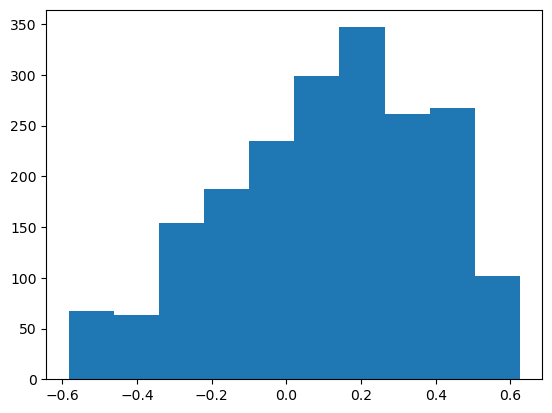

In [579]:
# before training
output = model(X_test)
plt.hist(output.detach().numpy())

Accuracy on test set :  0.4551411271095276


(array([ 229.,    0.,    0.,    0.,    0., 1106.,    0.,    0.,    0.,
         649.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

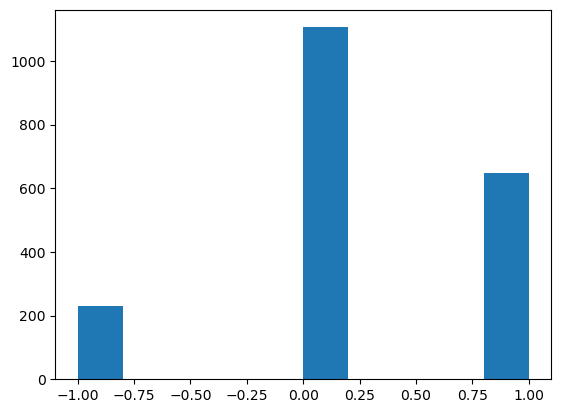

In [580]:
pred = torch.where(output > 0.25, 1, 0) + torch.where(output < -0.25, -1, 0)
print("Accuracy on test set : ", (torch.sum(pred==y_test)/len(y_test)).item())
plt.hist(pred.detach().numpy())

In [581]:
l_losses = []
l_param = []
for i in range(10000):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l_losses.append(loss.item())
    l_param.append((model.alpha.item(), model.t.item()))

Text(0.5, 1.0, 'Offset t')

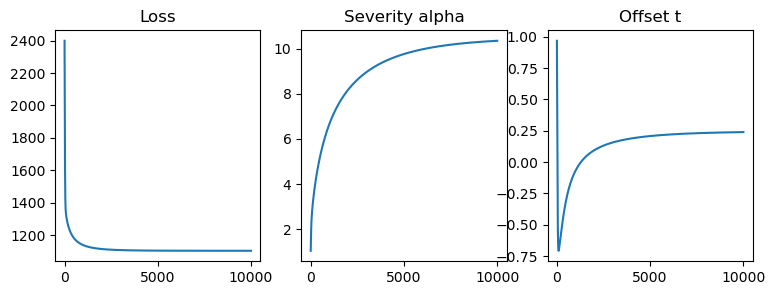

In [582]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot(l_losses)
ax[0].set_title("Loss")
ax[1].plot([x[0] for x in l_param])
ax[2].plot([x[1] for x in l_param])
ax[1].set_title("Severity alpha")
ax[2].set_title("Offset t")

(array([370., 100.,  63.,  59.,  54.,  91.,  79.,  94., 147., 927.]),
 array([-9.9994844e-01, -7.9995930e-01, -5.9997010e-01, -3.9998093e-01,
        -1.9999176e-01, -2.5928020e-06,  1.9998658e-01,  3.9997575e-01,
         5.9996492e-01,  7.9995406e-01,  9.9994326e-01], dtype=float32),
 <BarContainer object of 10 artists>)

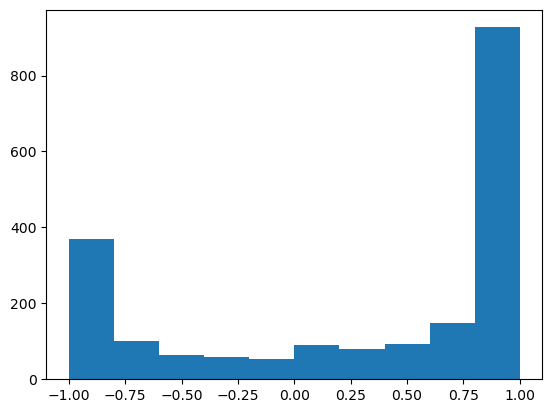

In [583]:
# after training
output = model(X_test)
plt.hist(output.detach().numpy())

Accuracy on test set :  0.8447580933570862


(array([ 581.,    0.,    0.,    0.,    0.,  172.,    0.,    0.,    0.,
        1231.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

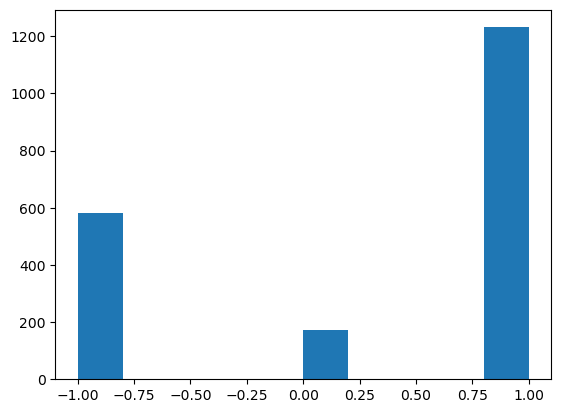

In [584]:
pred = torch.where(output > 0.25, 1, 0) + torch.where(output < -0.25, -1, 0)
print("Accuracy on test set : ", (torch.sum(pred==y_test)/len(y_test)).item())
plt.hist(pred.detach().numpy())

### MLP

In [599]:
df = df_fights[["R_fighter",	"B_fighter", "date", "Winner"]].merge(
    df_ratings[["fighter","date","won_total", "lost_total", "draw_total"]].groupby(["fighter","date"]).agg({"won_total":"first", "lost_total":"first", "draw_total":"first"}).reset_index(),
    how="left", left_on=["R_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"won_total":"R_won_total",
                      "lost_total":"R_lost_total",
                      "draw_total":"R_draw_total",
                      }).drop(columns="fighter").merge(
    df_ratings[["fighter","date","won_total", "lost_total", "draw_total"]].groupby(["fighter","date"]).agg({"won_total":"first", "lost_total":"first", "draw_total":"first"}).reset_index(),
    how="left", left_on=["B_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"won_total":"B_won_total",
                      "lost_total":"B_lost_total",
                      "draw_total":"B_draw_total",
                      }).drop(columns="fighter")
y= torch.tensor(df["Winner"].map({"Red":1, "Draw":0, "Blue":-1}), dtype=torch.float32)
X = torch.tensor(df[["R_won_total",	"R_lost_total",	"R_draw_total",	"B_won_total",	"B_lost_total",	"B_draw_total"]].values, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
df

,R_fighter,B_fighter,date,Winner,R_won_total,R_lost_total,R_draw_total,B_won_total,B_lost_total,B_draw_total
0,Adrian Yanez,Gustavo Lopez,2021-03-20,Red,2,0,0,1,2,0
1,Trevin Giles,Roman Dolidze,2021-03-20,Red,5,2,0,2,1,0
2,Tai Tuivasa,Harry Hunsucker,2021-03-20,Red,5,3,0,0,1,0
3,Cheyanne Buys,Montserrat Conejo,2021-03-20,Blue,0,1,0,1,0,0
4,Marion Reneau,Macy Chiasson,2021-03-20,Blue,5,6,1,5,1,0
...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,1994-03-11,Red,0,1,0,0,1,0
6008,Orlando Wiet,Robert Lucarelli,1994-03-11,Red,0,1,0,0,1,0
6009,Johnny Rhodes,David Levicki,1994-03-11,Red,0,1,0,0,1,0
6010,Patrick Smith,Ray Wizard,1994-03-11,Red,1,0,0,0,1,0


In [657]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = -1+2*self.sigmoid(output)
        return output

Accuracy on test set :  0.8780242204666138


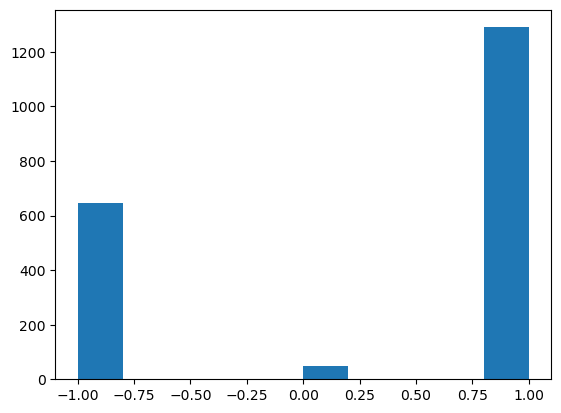

In [664]:
model = MLP(6, 1000)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

l_losses = []
for i in range(1000):
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l_losses.append(loss.item())

output = model(X_test)
pred = torch.where(output > 0.25, 1, 0) + torch.where(output < -0.25, -1, 0)
print("Accuracy on test set : ", (torch.sum(pred.squeeze()==y_test)/len(y_test)).item())
plt.hist(pred.detach().numpy());

Accuracy on test set :  0.8865927457809448


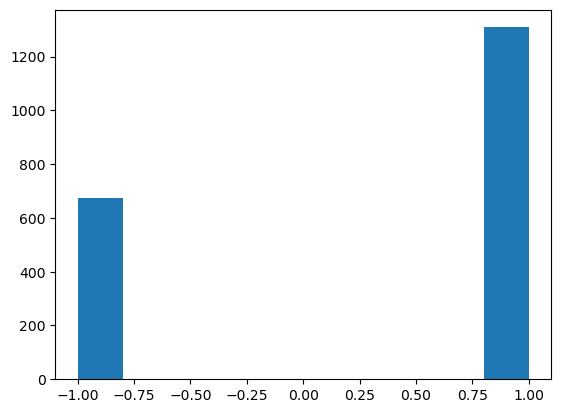

In [679]:
thresh = -0.0
output = model(X_test)
pred = torch.where(output > thresh, 1, 0) + torch.where(output < -thresh, -1, 0)
print("Accuracy on test set : ", (torch.sum(pred.squeeze()==y_test)/len(y_test)).item())
plt.hist(pred.detach().numpy());

Text(0.5, 1.0, 'Loss')

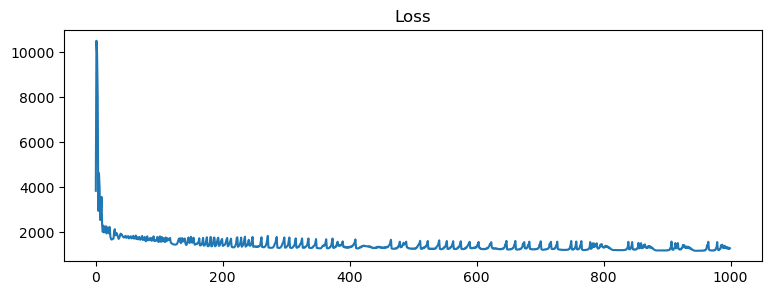

In [665]:
fig, ax = plt.subplots(1,1, figsize=(9,3))
ax.plot(l_losses)
ax.set_title("Loss")

(array([ 593.,   26.,   22.,   15.,   18.,   16.,   22.,   20.,   47.,
        1205.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

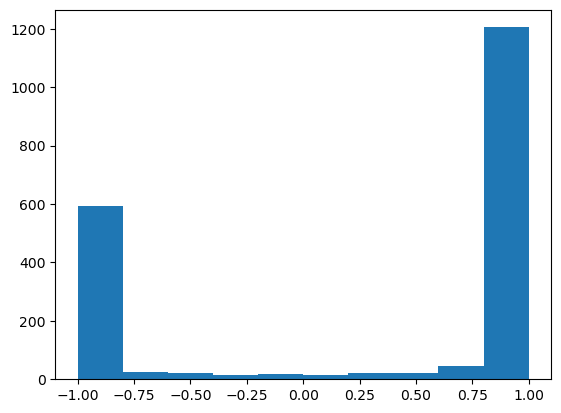

In [666]:
# after training
output = model(X_test)
plt.hist(output.detach().numpy())

### Siamese scalar MLP
We need a real function to perform a ranking
A siamese MLP computes a scalar value for each win loss draw ratio

In [680]:
df = df_fights[["R_fighter",	"B_fighter", "date", "Winner"]].merge(
    df_ratings[["fighter","date","won_total", "lost_total", "draw_total"]].groupby(["fighter","date"]).agg({"won_total":"first", "lost_total":"first", "draw_total":"first"}).reset_index(),
    how="left", left_on=["R_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"won_total":"R_won_total",
                      "lost_total":"R_lost_total",
                      "draw_total":"R_draw_total",
                      }).drop(columns="fighter").merge(
    df_ratings[["fighter","date","won_total", "lost_total", "draw_total"]].groupby(["fighter","date"]).agg({"won_total":"first", "lost_total":"first", "draw_total":"first"}).reset_index(),
    how="left", left_on=["B_fighter", "date"], right_on=["fighter", "date"]
    ).rename(columns={"won_total":"B_won_total",
                      "lost_total":"B_lost_total",
                      "draw_total":"B_draw_total",
                      }).drop(columns="fighter")
y= torch.tensor(df["Winner"].map({"Red":1, "Draw":0, "Blue":-1}), dtype=torch.float32)
X = torch.tensor(df[["R_won_total",	"R_lost_total",	"R_draw_total",	"B_won_total",	"B_lost_total",	"B_draw_total"]].values, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
df

,R_fighter,B_fighter,date,Winner,R_won_total,R_lost_total,R_draw_total,B_won_total,B_lost_total,B_draw_total
0,Adrian Yanez,Gustavo Lopez,2021-03-20,Red,2,0,0,1,2,0
1,Trevin Giles,Roman Dolidze,2021-03-20,Red,5,2,0,2,1,0
2,Tai Tuivasa,Harry Hunsucker,2021-03-20,Red,5,3,0,0,1,0
3,Cheyanne Buys,Montserrat Conejo,2021-03-20,Blue,0,1,0,1,0,0
4,Marion Reneau,Macy Chiasson,2021-03-20,Blue,5,6,1,5,1,0
...,...,...,...,...,...,...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,1994-03-11,Red,0,1,0,0,1,0
6008,Orlando Wiet,Robert Lucarelli,1994-03-11,Red,0,1,0,0,1,0
6009,Johnny Rhodes,David Levicki,1994-03-11,Red,0,1,0,0,1,0
6010,Patrick Smith,Ray Wizard,1994-03-11,Red,1,0,0,0,1,0


In [696]:
class SiameseMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x1, x2 = x[:,:3], x[:,3:]
        h1 = self.fc1(x1)
        h2 = self.fc1(x2)
        relu1 = self.relu(h1)
        relu2 = self.relu(h2)
        output1 = self.fc2(relu1)
        output2 = self.fc2(relu2)
        output = -1+2*self.sigmoid(output1-output2)
        return output
    
    def rate(self, x):
        h = self.fc1(x)
        relu = self.relu(h)
        output = self.fc2(relu)
        return output

In [697]:
model = SiameseMLP(3, 100)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

Accuracy on test set :  0.8477822542190552


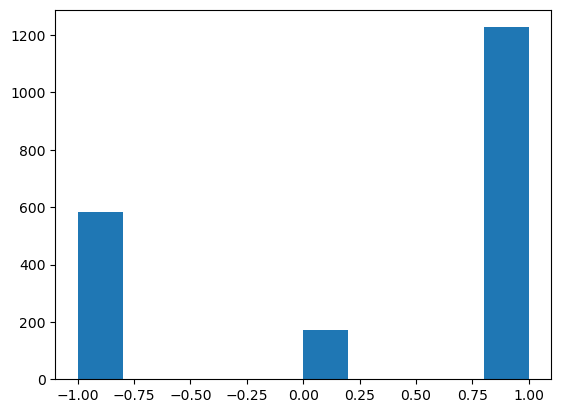

In [698]:
l_losses = []
for i in range(1000):
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l_losses.append(loss.item())

output = model(X_test)
pred = torch.where(output > 0.25, 1, 0) + torch.where(output < -0.25, -1, 0)
print("Accuracy on test set : ", (torch.sum(pred.squeeze()==y_test)/len(y_test)).item())
plt.hist(pred.detach().numpy());

In [699]:
model.rate(X_train[:,:3])

tensor([[-3.2623],
        [ 2.9616],
        [ 2.9616],
        ...,
        [-0.0822],
        [ 3.8470],
        [ 1.3336]], grad_fn=<AddmmBackward0>)

In [705]:
model.rate(torch.tensor([
    [1,1,1],
    [10,1,1],
    [1,10,1],
    [10,10,0],
], dtype=torch.float32))

tensor([[ -0.8181],
        [  2.6027],
        [-13.7967],
        [ -1.9428]], grad_fn=<AddmmBackward0>)

### Raw win prediction with PageRank (no temporality)

In [850]:
rows = []
for i in range(len(df_preprocessed)):
    G = create_contactNetwork(df_preprocessed.loc[np.where(df_preprocessed.index == i, False, True)])
    rows.append(df_preprocessed.loc[[i]].merge(pd.Series(nx.pagerank(G), name="pr_winner"), how="left", left_on="Winner", right_index=True
                               ).merge(pd.Series(nx.pagerank(G), name="pr_loser"), how="left", left_on="Loser", right_index=True))
    

In [851]:
df = pd.concat(rows)
df = df.dropna().loc[df["weight"]!=0.5]
df = df.loc[~((df["pr_winner"]==0)&(df["pr_loser"]==0))]
df["best_pr_won"] = df["pr_winner"]>df["pr_loser"]
df["best_pr_won"].sum()/len(df)

0.6634754335260116

In [783]:
df

,Winner,Loser,date,weight,pr_winner,pr_loser,best_pr_won
220,Adrian Yanez,Gustavo Lopez,2021-03-20,1.0,0.000162,0.000141,True
221,Trevin Giles,Roman Dolidze,2021-03-20,1.0,0.000717,0.000176,True
224,Macy Chiasson,Marion Reneau,2021-03-20,1.0,0.000390,0.000545,False
225,Grant Dawson,Leonardo Santos,2021-03-20,1.0,0.000666,0.001941,False
226,Max Griffin,Song Kenan,2021-03-20,1.0,0.000344,0.000222,True
...,...,...,...,...,...,...,...
6108,Patrick Smith,Scott Morris,1994-03-11,1.0,0.000438,0.000162,True
6109,Royce Gracie,Remco Pardoel,1994-03-11,1.0,0.001365,0.000374,True
6110,Remco Pardoel,Orlando Wiet,1994-03-11,1.0,0.000237,0.000162,True
6111,Patrick Smith,Johnny Rhodes,1994-03-11,1.0,0.000374,0.000237,True


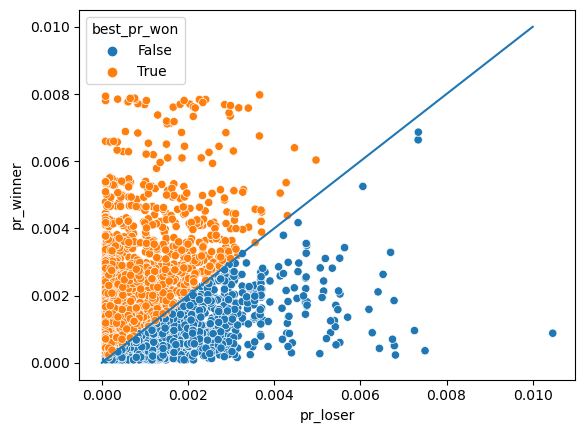

In [787]:
sns.scatterplot(df, x="pr_loser", y="pr_winner", hue="best_pr_won")
# Generate x values
x = np.linspace(0, 0.01, 100)  # Generate 100 points between -10 and 10

# Calculate y values
y = x

plt.plot(y, y)

### Raw win prediction with credible PageRank (no temporality)

In [826]:
rows = []
for i in range(len(df_preprocessed)):
    G = create_contactNetwork(df_preprocessed.loc[np.where(df_preprocessed.index == i, False, True)])
    fighter0, fighter1 = df_preprocessed.loc[i, ["Winner", "Loser"]].values
    if have_sharedInfo(G, fighter0, fighter1):
        strengths = compute_relativeStrength(G, [fighter0, fighter1])[0]
        rows.append(df_preprocessed.loc[[i]].merge(pd.Series(strengths, name="cpr_winner"), how="left", left_on="Winner", right_index=True
                                ).merge(pd.Series(strengths, name="cpr_loser"), how="left", left_on="Loser", right_index=True))

In [848]:
df = pd.concat(rows)
df = df.dropna().loc[df["weight"]!=0.5]
df = df.loc[~((df["cpr_winner"]==0)&(df["cpr_loser"]==0))]
df["best_cpr_won"] = df["cpr_winner"]>df["cpr_loser"]
df["best_cpr_won"].sum()/len(df)

0.6649302325581395

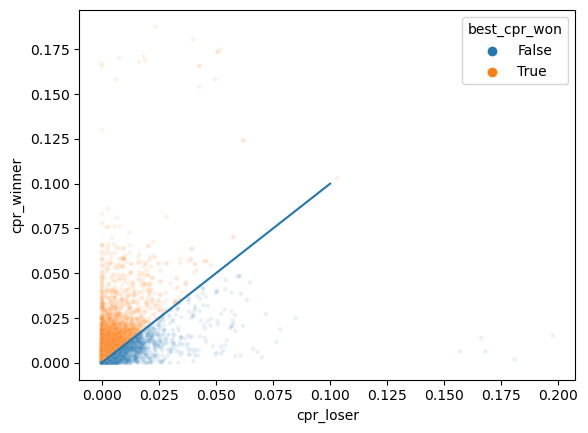

In [841]:
sns.scatterplot(df, x="cpr_loser", y="cpr_winner", hue="best_cpr_won", s=10, alpha=0.1)
# Generate x values
x = np.linspace(0, 0.1, 100)  # Generate 100 points between -10 and 10

# Calculate y values
y = x

plt.plot(y, y)

# <>

### GNN edge direction prediction